In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.datasets import VOCSegmentation, Cityscapes
from PIL import Image
from tqdm import tqdm
from matplotlib import colormaps

from utils import overlay_mask
from decode_heads import SegmentationHead

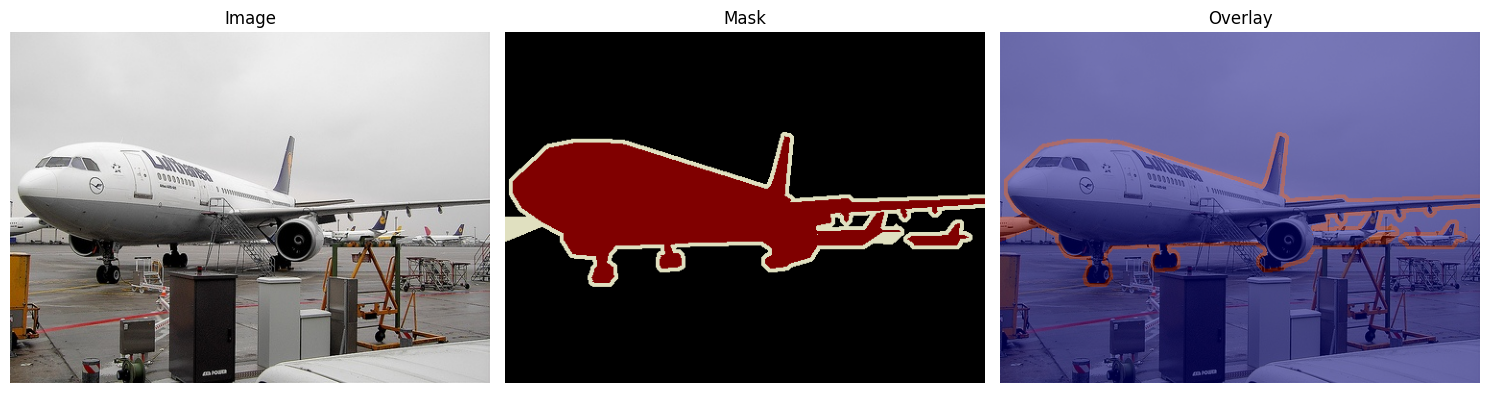

In [2]:
def overlay_mask(img, seg_mask, title: str = "Overlay", alpha = 0.5):
    if isinstance(img, Tensor):
        if img.ndim == 4:
            img = img.squeeze(0)
        img = img.permute(1, 2, 0)
    if isinstance(seg_mask, Tensor):
        if seg_mask.ndim == 4:
            seg_mask = seg_mask.squeeze(0)
        # Only permute if seg_mask has 3 dims (C, H, W)
        if seg_mask.ndim == 3:
            seg_mask = seg_mask.permute(1, 2, 0)
    img, seg_mask = np.asarray(img), np.asarray(seg_mask)
    cmap = colormaps['jet']
    colored_mask = cmap(seg_mask / seg_mask.max())[:, :, :3]  # Drop alpha channel
    return (1 - alpha) * img / 255.0 + alpha * colored_mask


dataset = VOCSegmentation("VOC2012", image_set="val")
img, mask = next(iter(dataset))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay_mask(img, mask))
plt.axis("off")

plt.tight_layout()
plt.show()

# VOC - Semantic Segmentation

In [ ]:
class SimpleSegNet(nn.Module):
    def __init__(self, num_classes=21):
        super(SimpleSegNet, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),   # (B, 32, H, W)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                 # (B, 32, H/2, W/2)
            
            nn.Conv2d(32, 64, 3, padding=1),  # (B, 64, H/2, W/2)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                 # (B, 64, H/4, W/4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, 2, stride=2),  # (B, 32, H/2, W/2)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, 2, stride=2)  # (B, num_classes, H, W)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

L_RATE = 0.001
B_SIZE = 64
EPOCHS = 5
IMG_SIZE = (128, 128)

transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor()
])

target_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BILINEAR),
    T.PILToTensor(),  # returns (1, H, W)
    T.Lambda(lambda x: x.squeeze().long())  # -> (H, W), long type
])

trainset = VOCSegmentation("VOC2012", image_set="train", transform=transform, target_transform=target_transform)
testset = VOCSegmentation("VOC2012", image_set="val", transform=transform, target_transform=target_transform)

model = SimpleSegNet()
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optim = torch.optim.Adam(model.parameters())

train_loader = DataLoader(trainset, B_SIZE, shuffle=True)
test_loader = DataLoader(testset, B_SIZE)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    ## Training
    losses = []
    model.train()
    for img, mask in tqdm(train_loader, desc=f"[{epoch+1}/{EPOCHS}] Training"):
        optim.zero_grad()

        pred = model(img)
        loss = loss_fn(pred, mask)
        losses.append(loss.item())

        loss.backward()
        optim.step()
    
    train_losses.append(np.mean(losses))

    ## Evaluation
    losses = []
    model.eval()
    for img, mask in tqdm(test_loader, desc=f"   Evaluating"):
        with torch.no_grad():
            pred = model(img)
            loss = loss_fn(pred, mask)
            losses.append(loss.item())
        
    test_losses.append(np.mean(losses))

print("DONE!")

	  Evaluating: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]

DONE!


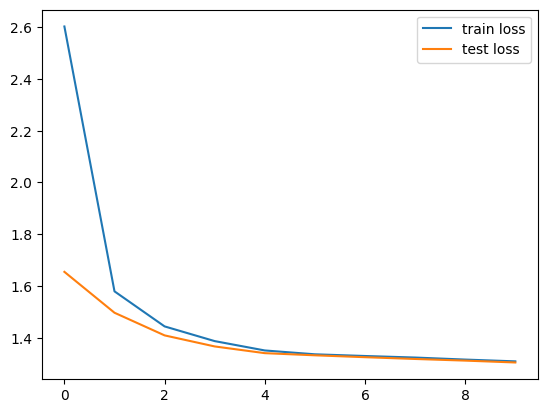

In [4]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

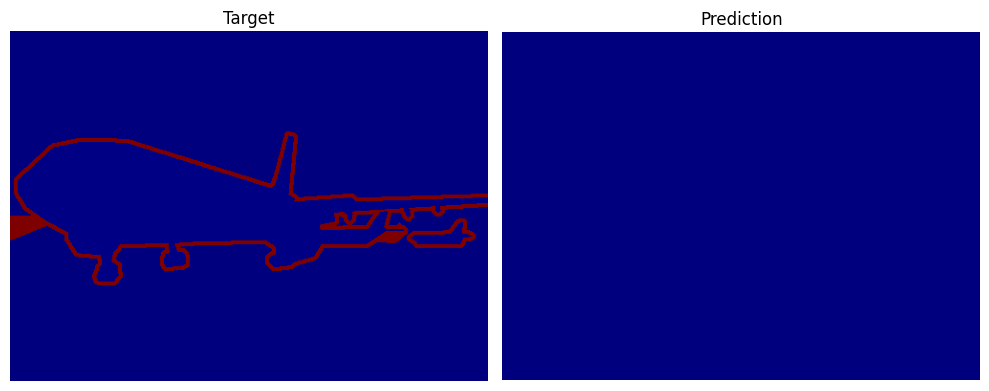

In [ ]:
# Get a sample
img, mask = next(iter(dataset))

# Ensure img is a float tensor with batch dimension
img_tensor = T.ToTensor()(img).unsqueeze(0)  # shape: (1, 3, H, W)

# Run prediction
with torch.no_grad():
    pred = model(img_tensor)  # shape: (1, C, H, W)
    pred_mask = pred.argmax(dim=1).squeeze(0).cpu().numpy()  # shape: (H, W)

# Convert mask to numpy (assume mask is (H, W))
target_mask = mask.numpy() if torch.is_tensor(mask) else np.array(mask)

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Target")
plt.imshow(target_mask, cmap='jet')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(pred_mask, cmap='jet')
plt.axis("off")

plt.tight_layout()
plt.show()